In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!pip list

Package                       Version
----------------------------- ---------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array-record                  0.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         23.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
build                         0.10.0
CacheControl                  0.12.11
ca

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = '/content/drive/MyDrive/self_made_ds' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [10]:
len(os.listdir('/content/drive/MyDrive/self_made_ds/UnRipe'))

814

# 3. Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os

In [12]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/self_made_ds')

Found 2477 files belonging to 3 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
batch = data_iterator.next()

In [15]:
classes = data.class_names
classes

['OverRipe', 'Ripe', 'UnRipe']

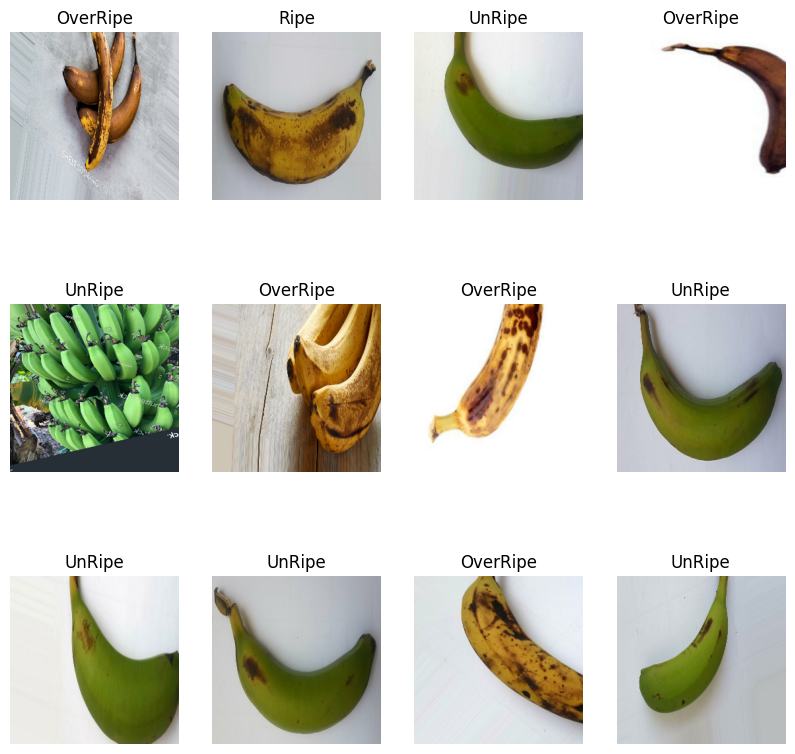

In [16]:
plt.figure(figsize =(10,10))

for image_batch, label_batch in data.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.title(classes[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

# 4. Scale Data

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [18]:
data.as_numpy_iterator().next()

(array([[[[0.9019608 , 0.9019608 , 0.9098039 ],
          [0.9019608 , 0.9019608 , 0.9098039 ],
          [0.90588236, 0.90588236, 0.9137255 ],
          ...,
          [0.8802083 , 0.8841299 , 0.8606005 ],
          [0.8798177 , 0.8837393 , 0.8602099 ],
          [0.8899663 , 0.8938879 , 0.87035847]],
 
         [[0.9019608 , 0.9019608 , 0.9098039 ],
          [0.9019608 , 0.9019608 , 0.9098039 ],
          [0.9033701 , 0.9033701 , 0.9112132 ],
          ...,
          [0.8745098 , 0.8784314 , 0.85490197],
          [0.88560814, 0.8895297 , 0.8660003 ],
          [0.8793888 , 0.8833104 , 0.85978097]],
 
         [[0.9019608 , 0.9019608 , 0.9098039 ],
          [0.9019608 , 0.9019608 , 0.9098039 ],
          [0.8989507 , 0.8989507 , 0.90679383],
          ...,
          [0.8773897 , 0.8813113 , 0.8577819 ],
          [0.8782935 , 0.8822151 , 0.8586857 ],
          [0.8752298 , 0.87915134, 0.85562193]],
 
         ...,
 
         [[0.78039217, 0.77254903, 0.7764706 ],
          [0.78039

# 5. Split Data

In [19]:
def get_dataset_partitions(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 57)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train, val, test = get_dataset_partitions(data)

In [21]:
print(len(train), len(val), len(test))

62 7 9


# 6. Build InceptionV3 model

In [22]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [24]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your own top layers to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # Replace `num_classes` with the number of classes in your problem

model = Model(inputs=base_model.input, outputs=predictions)



87910968/87910968 [==============================] - 5s 0us/step


In [25]:
# Compile the model with your chosen optimizer and loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [27]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = 'model.png', show_shapes=True,show_layer_names=True)


Output hidden; open in https://colab.research.google.com to view.

# 7. Train

In [28]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
62/62 [==============================] - 47s 336ms/step - loss: 0.5172 - accuracy: 0.8132 - val_loss: 0.1944 - val_accuracy: 0.9152
Epoch 2/20
62/62 [==============================] - 28s 264ms/step - loss: 0.1718 - accuracy: 0.9379 - val_loss: 0.0999 - val_accuracy: 0.9777
Epoch 3/20
62/62 [==============================] - 28s 270ms/step - loss: 0.1165 - accuracy: 0.9623 - val_loss: 0.0810 - val_accuracy: 0.9777
Epoch 4/20
62/62 [==============================] - 28s 270ms/step - loss: 0.1151 - accuracy: 0.9552 - val_loss: 0.0801 - val_accuracy: 0.9732
Epoch 5/20
62/62 [==============================] - 28s 267ms/step - loss: 0.0660 - accuracy: 0.9786 - val_loss: 0.0543 - val_accuracy: 0.9911
Epoch 6/20
62/62 [==============================] - 27s 268ms/step - loss: 0.0732 - accuracy: 0.9781 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 7/20
62/62 [==============================] - 27s 263ms/step - loss: 0.0573 - accuracy: 0.9812 - val_loss: 0.0676 - val_accuracy: 0.9732

In [29]:
test_loss, test_accuracy = model.evaluate(test)
print("test loss:",test_loss)
print("test accuracy:",test_accuracy)

9/9 [==============================] - 11s 95ms/step - loss: 0.0049 - accuracy: 1.0000
test loss: 0.004946253262460232
test accuracy: 1.0


In [30]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# 8. Plot Performance

In [31]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

In [32]:
EPOCHS = 20

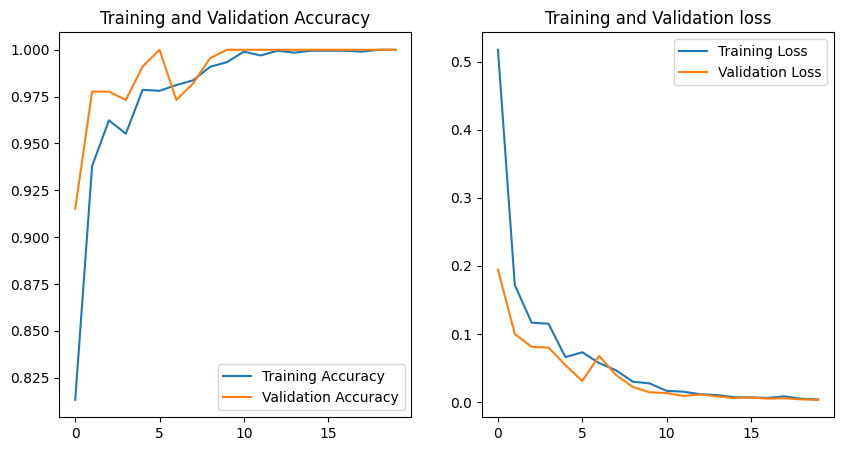

In [40]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)

# Graph of training and validation accuracy
plt.plot(range(EPOCHS), acc, label= 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc ,  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

#Graph of training and validation loss
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = "upper right")
plt.title("Training and Validation loss")
plt.show()

# Model Saving

In [41]:
model.save('/content/drive/MyDrive/INCEPTIONV3.h5')

# 9. Evaluate

In [34]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall

In [35]:
categorical_acc = CategoricalAccuracy()
precision = Precision()
recall = Recall()

In [45]:
# Since our y is not in one hot encoded format
y

array([1, 1, 1, 2, 0, 1, 2, 2, 2, 0, 2, 1, 1, 2, 2, 0, 2, 0, 2, 1, 0, 0,
       0, 2, 2, 0, 2, 2, 1, 1, 0, 0], dtype=int32)

In [48]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    y_categorical = np.eye(3)[y]  # Convert categorical labels to one-hot encoded format
    categorical_acc.update_state(y_categorical, yhat)
    precision.update_state(y_categorical, yhat)
    recall.update_state(y_categorical, yhat)

accuracy = categorical_acc.result()
precision_result = precision.result()
recall_result = recall.result()

1/1 [==============================] - 0s 37ms/step


In [49]:
print("Accuracy:", accuracy)
print("Precision:", precision_result)
print("Recall:", recall_result)

Accuracy: tf.Tensor(0.925, shape=(), dtype=float32)
Precision: tf.Tensor(1.0, shape=(), dtype=float32)
Recall: tf.Tensor(1.0, shape=(), dtype=float32)


In [76]:
from sklearn.metrics import f1_score

# Calculate the F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("F1 Score:", f1)


F1 Score: 1.0


# Classification report and Confusion Matrix

In [55]:
y_pred_classes = []
y_true_classes = []

for batch in test:
    X, y = batch
    y_pred = model.predict(X)
    y_pred_classes.extend(np.argmax(y_pred, axis=1))
    y_true_classes.extend(y)

y_pred_classes = np.array(y_pred_classes)
y_true_classes = np.array(y_true_classes)

print("y_pred_classes shape:", y_pred_classes.shape)
print("y_true_classes shape:", y_true_classes.shape)


1/1 [==============================] - 0s 35ms/step
y_pred_classes shape: (288,)
y_true_classes shape: (288,)


In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Classification Report:
              precision    recall  f1-score   support

        ripe       1.00      1.00      1.00        98
      unripe       1.00      1.00      1.00       102
    overripe       1.00      1.00      1.00        88

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



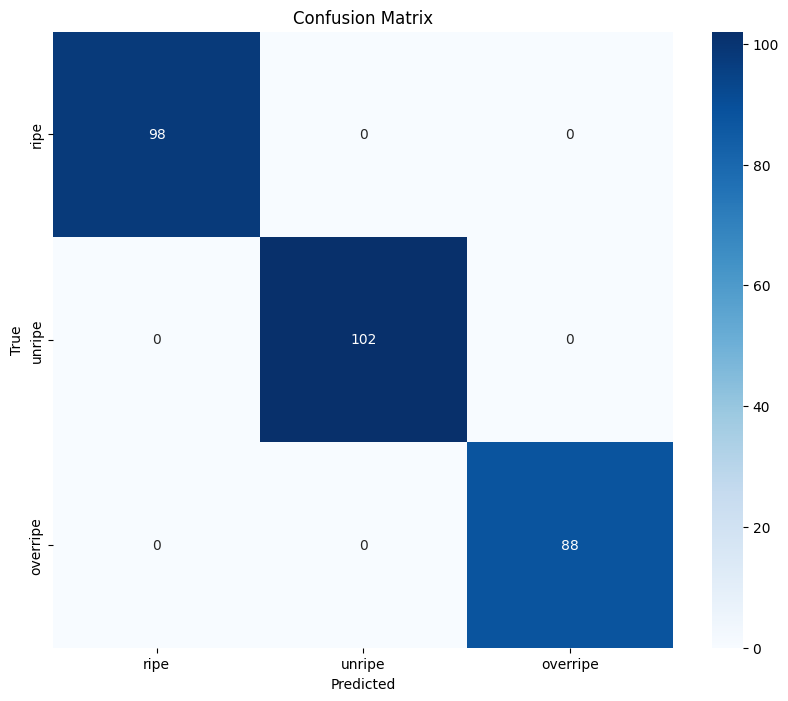

In [58]:

# Compute the classification report
class_names = ['ripe', 'unripe', 'overripe']
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(classification_rep)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 10. Test

In [59]:
import cv2

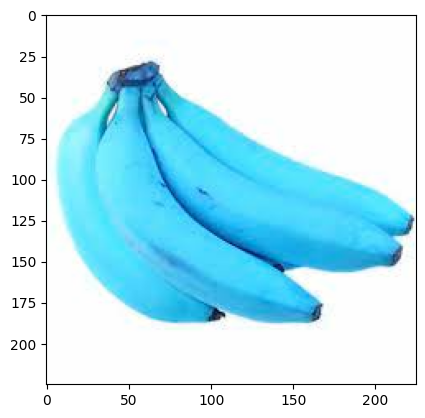

In [71]:
img = cv2.imread('/content/download.jpg')
plt.imshow(img)
plt.show()

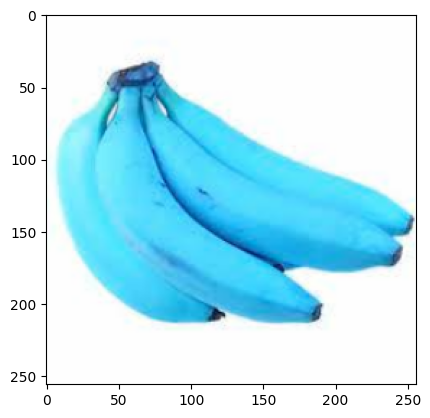

In [72]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [73]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 29ms/step


In [74]:
yhat

array([[2.5627514e-05, 9.2004210e-01, 7.9932265e-02]], dtype=float32)

In [75]:
class_indices = {0: 'Overripe', 1: 'Ripe', 2: 'Unripe'}
predicted_class_index = np.argmax(yhat)
predicted_class = class_indices[predicted_class_index]
print("Predicted class:", predicted_class)

Predicted class: Ripe
